In [ ]:
## This is a series of examples using the icanswim/cosmosis data science and machine learning repo

In [1]:
from model import FFNet, tv_model
from learning import Learn, Selector, Metrics
from dataset import SKDS, TVDS, CDataset, ImageDatasetStats, AsTensor, Squeeze, DType

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

In [2]:
## Example of generic/custom dataset and transforms
import numpy as np

class DummyDataset(CDataset):

    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([.02]),
                       'feature_3': np.asarray(['c']),
                       'feature_4': np.asarray(['b','a']),
                       'feature_5': np.asarray([1.1])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([.01]),
                       'feature_3': np.asarray(['a','b','d']),
                       'feature_4': np.asarray(['d']),
                       'feature_5': np.asarray([1.2])}}
        
        print(boom)
        return datadic
    
class DummyTransform():
    def __call__(self, arr):
        return np.add(arr, 2)
    
class DummyTransformTwo():
    def __call__(self, arr):
        return np.multiply(arr, .1)
    
ds_params = {'train_params': {'features': ['feature_1','feature_5'],
                              'embeds': ['feature_3','feature_4'],
                              'targets': ['feature_2'],
                              'embed_lookup': {'a': 1, 'b': 2, 'c': 3, 'd': 4, '0': 0},
                              'transform': [DummyTransform(), DummyTransformTwo()],
                              'target_transform': [],
                              'pad': 5,
                              'do_not_pad': ['feature_1','feature_2','feature_3'],
                              'boom': 'bang'}}
    
d = DummyDataset(**ds_params['train_params'])
d[2]

bang
CDataset created...


{'X': tensor([0.2030, 0.3200, 0.2000, 0.2000, 0.2000, 0.2000], dtype=torch.float64),
 'embed_idx': [array([1, 2, 4]), array([4, 0, 0, 0, 0])],
 'y': array([0.01])}

In [3]:
## Example of sklearn regression dataset wrapper
ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'make': 'make_regression',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 5},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32'}}

sk = SKDS(**ds_params['train_params'])

sk[1]

CDataset created...
SKDS make_regression created...


{'X': tensor([-0.4675,  1.3549, -0.4919,  0.2158,  0.1509]),
 'y': array([71.26179], dtype=float32)}

In [4]:
## Example of sklearn classification dataset wrapper
ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'make': 'make_classification',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 10,
                                            'n_informative': 8,
                                            'n_clusters_per_class': 2,
                                            'flip_y': 0.05,
                                            'class_sep': 0.01,
                                            'n_classes': 4}}}

sk = SKDS(**ds_params['train_params'])

sk[1]

CDataset created...
SKDS make_classification created...


{'X': tensor([ 0.5951, -1.2652, -2.3226, -1.7339,  3.4983, -5.0725,  0.9133,  1.3050,
         -4.1057, -5.1095]),
 'y': array([0])}

In [5]:
## Example of torchvision wrapper
ds_params={'dataset': 'MNIST',
           'features': ['images'],
           'targets': ['labels'],
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
tvds[1]

CDataset created...
TVDS created...


{'image': <PIL.Image.Image image mode=L size=224x224 at 0x7F2D48289820>,
 'y': 0}

In [6]:
## Example of torchvision dataset wrapper with PIL transform
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

CDataset created...
TVDS created...
images to process: 60000
images processed: 10000
images processed: 20000
images processed: 30000
images processed: 40000
images processed: 50000
images processed: 60000
mean: [33.33091590401786], stddev: [73.70246726596685]
mean:  [33.33091590401786]
stddev:  [73.70246726596685]


CDataset created...
SKDS make_regression created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:02.707593
epoch: 0, lr: 0.01
train loss: 582363.9010416666, val loss: 441025.32954545453
test loss: 11100.83260830966
learning time: 0:00:09.608484


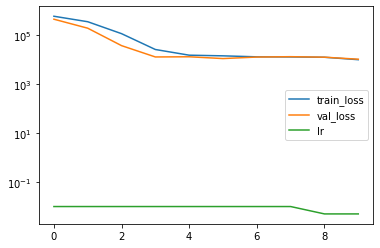

In [7]:
## Example sklearn regression dataset wrapper with custom model
model_params = {'D_in': 256, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'make': 'make_regression',
                              'as_tensor': True,
                              'transform': [],
                              'sk_params': {'n_samples':20000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10,
                  'log_plot': True}                         
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=10, gpu=True)

CDataset created...
SKDS make_classification created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:04.923856
epoch: 0, lr: 0.01
train loss: 1.357227779788412, val loss: 1.2872916938912156
sklearn train metric: 0.5729934952853624, sklearn validation metric: 0.6458396651965658
learning time: 0:00:19.402476
epoch: 3, lr: 0.01
train loss: 0.9378943915987189, val loss: 0.922650650016263
sklearn train metric: 0.8289999130790777, sklearn validation metric: 0.834852542710032
learning time: 0:00:33.812206
epoch: 6, lr: 0.01
train loss: 0.7424816528519431, val loss: 0.7784284541749547
sklearn train metric: 0.8883655907967065, sklearn validation metric: 0.8847873254703233
learning time: 0:00:48.317727
epoch: 9, lr: 0.01
train loss: 0.5335454592010477, val loss: 0.5979296302693522
sklearn train metric: 0.9454067282107058, sklearn validation metric: 0.9341712516667241
test loss: 0.5912594336729783
learning time: 0:00:48.922204
sklearn test metric: 
0.93626890

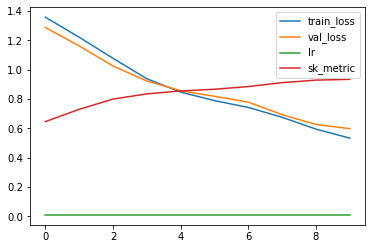

In [8]:
## Example sklearn classification dataset and metrics wrapper with custom model
model_params = {'D_in': 256, 
                'H': 128, 
                'D_out': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': 'X',
                              'targets': 'y',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'make': 'make_classification',
                              'sk_params': {'n_samples': 100000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=(300,256,.2), batch_size=128, epochs=10, squeeze_y=True, save_model=True)

In [9]:
## Example inference with a sklearn classification dataset and metrics wrapper with custom model
model_params = {'D_in': 256, 
                'H': 128, 
                'D_out': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': 'X',
                              'targets': 'y',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'make': 'make_classification',
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=None,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=128, epochs=1, squeeze_y=True, load_model='20220813_2127.pth')

CDataset created...
SKDS make_classification created...
FFNet model loaded...
CModel loaded...
model loaded from pickle...
running model on gpu...
inference 2022-08-13 21:29:08.554170 complete and saved to csv...


Files already downloaded and verified
CDataset created...
TVDS created...
Files already downloaded and verified
CDataset created...
TVDS created...
torchvision model resnet18 loaded...
running model on gpu...
learning time: 0:00:05.174320
epoch: 0, lr: 0.01
train loss: 2.3423563175201414, val loss: 2.005409896373749
sklearn train metric: 0.6294327435277395, sklearn validation metric: 0.739486041654238
learning time: 0:00:19.899102
epoch: 3, lr: 0.01
train loss: 1.784742769241333, val loss: 1.8064245466263062
sklearn train metric: 0.8002037635624498, sklearn validation metric: 0.8079071622376459
test loss: 1.7941962308883668
learning time: 0:00:23.781442
sklearn test metric: 
0.8109429222222222 



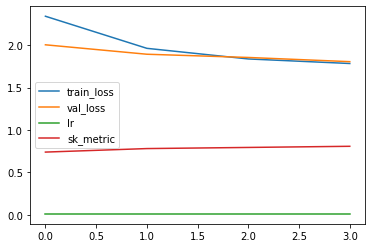

In [10]:
## Example torchvision dataset, transforms and model wrapper
model_params = {'model_name': 'resnet18',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(64),
                                                           transforms.ToTensor()]),
                                          'target_transform': None,
                                          'download': True}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(64),
                                                         transforms.ToTensor()]),
                                         'target_transform': None,
                                         'download': True}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params, 
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=16, epochs=4)

CDataset created...
TVDS created...
CDataset created...
TVDS created...
torchvision model resnext50_32x4d loaded...
running model on gpu...
learning time: 0:01:06.608903
epoch: 0, lr: 0.01
train loss: 2.6344470252990724, val loss: 2.160200999629113
sklearn train metric: 0.5444289352912508, sklearn validation metric: 0.6745913752177042
learning time: 0:02:13.218682
epoch: 1, lr: 0.01
train loss: 2.089339819431305, val loss: 2.0387291965946073
sklearn train metric: 0.6930617453782135, sklearn validation metric: 0.7294707817885506
learning time: 0:03:18.480115
epoch: 2, lr: 0.01
train loss: 2.0135356130599975, val loss: 2.054168297398475
sklearn train metric: 0.7243564531098485, sklearn validation metric: 0.7252793174518427
learning time: 0:04:22.660085
epoch: 3, lr: 0.01
train loss: 1.964889139652252, val loss: 1.944382590632285
sklearn train metric: 0.7408321885586308, sklearn validation metric: 0.7628797359765016
test loss: 1.9188650110244752
learning time: 0:05:07.030674
sklearn test 

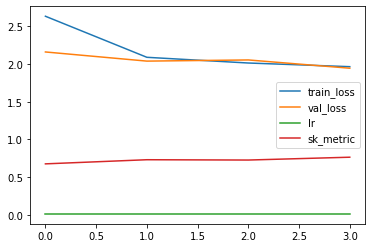

In [11]:
## Example torchvision dataset and model wrapper
model_params = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=16, epochs=4)